1) 데이터 로드: seaborn 'diamonds' 데이터셋
- 데이터 형태: (53940, 10)
2) 전처리+모델 파이프라인 구성 완료
3) 데이터 분할 완료: 학습 (43152, 9), 테스트 (10788, 9)
4) 모델 학습 시작 (전처리 → 개별모델 학습 → 스태킹)
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000256 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1295
[LightGBM] [Info] Number of data points in the train set: 43152, number of used features: 23
[LightGBM] [Info] Start training from score 3939.490707
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000469 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1267
[LightGBM] [Info] Number of data points in the train set: 28768, number of used features: 23
[LightGBM] [Info] Start training from score 3942.426585
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.0

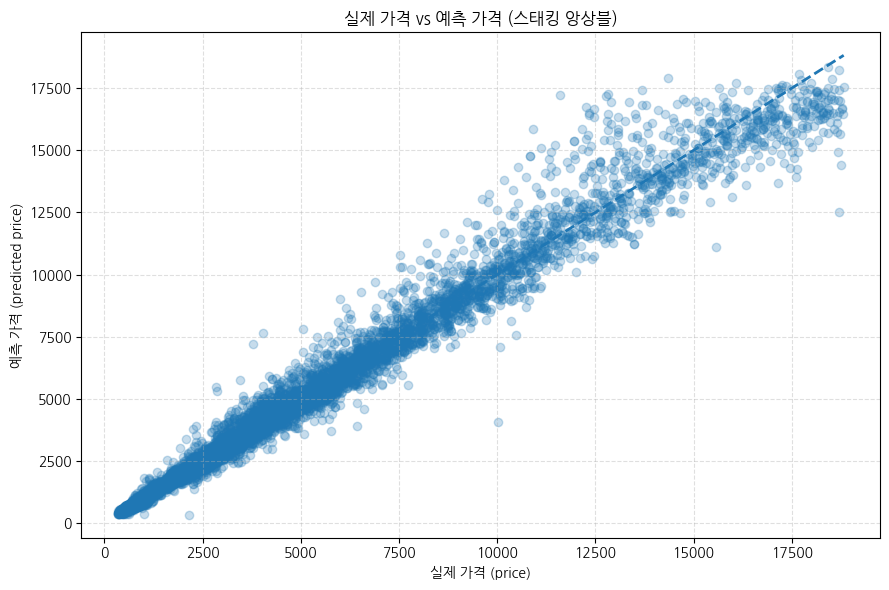

In [1]:
# ------------------------- [시각화 폰트(한글+이모지) 기본 세팅] -------------------------
import matplotlib.pyplot as plt  # 그래프 그리기
import matplotlib.font_manager as fm  # (선택) 폰트 관련 유틸
import platform  # 운영체제 감지용

# 운영체제별로 폰트 설정 (리눅스: 나눔고딕, 맥: 애플고딕, 윈도우: 맑은고딕)
if platform.system() == 'Linux':
    plt.rcParams['font.family'] = 'NanumGothic'
elif platform.system() == 'Darwin':
    plt.rcParams['font.family'] = 'AppleGothic'
else:
    plt.rcParams['font.family'] = 'Malgun Gothic'

# 마이너스 기호 깨짐 방지
plt.rcParams['axes.unicode_minus'] = False

# ------------------------- [필요 라이브러리 임포트] -------------------------
import pandas as pd               # 데이터 프레임 처리
import numpy as np                # 수치 연산
import seaborn as sns             # 예제 데이터셋 로드 및 EDA
from sklearn.model_selection import train_test_split            # 학습/평가 분리
from sklearn.preprocessing import OneHotEncoder, StandardScaler # 전처리(범주형/수치형)
from sklearn.compose import ColumnTransformer                   # 열별 전처리 조합
from sklearn.pipeline import Pipeline                           # 전처리+모델 묶기
from sklearn.metrics import mean_squared_error, r2_score        # 회귀 평가지표
from sklearn.ensemble import StackingRegressor                  # 스태킹 앙상블
from sklearn.linear_model import LinearRegression               # 최종 메타 모델

# 부스팅 3대장 (사전 설치 필요: xgboost, lightgbm, catboost)
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor

# 경고 숨기기(필수는 아님, 깔끔한 출력용)
import warnings
warnings.filterwarnings('ignore')

# ------------------------- [1) 데이터 로드] -------------------------
# seaborn 예제 데이터셋 'diamonds' 로드 (최초 1회는 인터넷에서 내려받아 로컬에 캐시될 수 있음)
print("1) 데이터 로드: seaborn 'diamonds' 데이터셋")
diamonds = sns.load_dataset('diamonds')
print(f"- 데이터 형태: {diamonds.shape}")  # (행, 열) 출력

# ------------------------- [2) 입력/타깃 분리] -------------------------
# 예측 대상(y): 가격(price), 입력 특성(X): 나머지 열
y = diamonds['price']           # 타깃 변수
X = diamonds.drop('price', axis=1)  # 입력 특성들

# ------------------------- [2-1) 특성 타입 분리] -------------------------
# 범주형(문자형) 컬럼과 수치형 컬럼을 지정
categorical_features = ['cut', 'color', 'clarity']              # 범주형
numerical_features   = ['carat', 'depth', 'table', 'x', 'y', 'z']  # 수치형

# ------------------------- [2-2) 전처리 파이프라인 정의] -------------------------
# 수치형 → 표준화(평균 0, 표준편차 1), 범주형 → 원-핫 인코딩
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),                         # 수치형 스케일링
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical_features)  # 범주형 원핫
    ],
    remainder='drop'  # 명시한 컬럼만 사용(나머지는 버림). 필요한 경우 'passthrough'로 유지 가능
)

# ------------------------- [3) 베이스 모델들 정의] -------------------------
# 스태킹의 1단계에서 사용할 개별 모델들(부스팅 3대장)
estimators = [
    ('lgbm', lgb.LGBMRegressor(random_state=42)),                  # LightGBM
    ('xgb',  xgb.XGBRegressor(random_state=42, n_estimators=300)), # XGBoost (트리 수 가벼게 상향)
    ('cat',  CatBoostRegressor(verbose=0, random_state=42))        # CatBoost (학습 로그 숨김)
]

# ------------------------- [4) 스태킹 회귀기 정의] -------------------------
# 개별 모델들의 예측을 모아 최종 선형회귀가 종합 판단
stacking_regressor = StackingRegressor(
    estimators=estimators,                 # 1단계 모델들
    final_estimator=LinearRegression(),    # 2단계 메타 모델(선형 회귀)
    cv=3                                   # 1단계 예측 생성 시 3겹 교차검증 사용
)

# ------------------------- [5) 전처리 + 모델을 하나의 파이프라인으로 묶기] -------------------------
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),        # 입력데이터 전처리
    ('regressor', stacking_regressor)      # 스태킹 앙상블 모델
])

print("2) 전처리+모델 파이프라인 구성 완료")

# ------------------------- [6) 학습/테스트 데이터 분할] -------------------------
# 데이터셋을 8:2로 분할(재현성을 위해 random_state 고정)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)
print(f"3) 데이터 분할 완료: 학습 {X_train.shape}, 테스트 {X_test.shape}")

# ------------------------- [7) 모델 학습] -------------------------
print("4) 모델 학습 시작 (전처리 → 개별모델 학습 → 스태킹)")
model_pipeline.fit(X_train, y_train)  # 파이프라인 하나로 전처리+학습이 한 번에 수행됨
print("   - 학습 완료!")

# ------------------------- [8) 예측 및 평가] -------------------------
print("5) 테스트 데이터 예측 및 평가지표 계산")
y_pred = model_pipeline.predict(X_test)                  # 예측값
mse = mean_squared_error(y_test, y_pred)                 # 평균제곱오차 (낮을수록 좋음)
r2  = r2_score(y_test, y_pred)                           # 결정계수 R^2 (1에 가까울수록 좋음)

print(f"   - MSE(평균제곱오차): {mse:,.2f}")
print(f"   - R²(결정계수): {r2:.4f}")

# ------------------------- [9) 시각화: 실제값 vs 예측값 산점도] -------------------------
plt.figure(figsize=(9, 6))                                 # 그림 크기
plt.scatter(y_test, y_pred, alpha=0.25)                    # 실제 vs 예측 산점도(투명도 0.25)
# 대각선 기준선(이 선과 가까울수록 예측이 정확)
min_val, max_val = y_test.min(), y_test.max()
plt.plot([min_val, max_val], [min_val, max_val], linestyle='--', linewidth=2)

plt.title("실제 가격 vs 예측 가격 (스태킹 앙상블)")
plt.xlabel("실제 가격 (price)")
plt.ylabel("예측 가격 (predicted price)")
plt.grid(axis='both', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()
